In [ ]:
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


# Importing required libraries

In [ ]:
import os
import cv2
import math
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

#Defining some constants

In [ ]:
SEED = 909
TRAIN_BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

HEIGHT = 128
WIDTH =128
IMAGE_SIZE = (HEIGHT, WIDTH)

TRAIN_SIZE = 21894
TEST_SIZE = 6551

EPOCHS = 25

#Defining paths for inputting data

In [ ]:
# Path to root folder
root_dir = '/content/drive/MyDrive/slices/'

# Path for training data
train_dir = os.path.join(root_dir, 'train')
train_image_dir = os.path.join(train_dir, 'Images')
train_label_dir = os.path.join(train_dir, 'Labels')

# Path for validation data
validate_dir = os.path.join(root_dir, 'validate/')
validate_image_dir = os.path.join(validate_dir, 'Images')
validate_label_dir = os.path.join(validate_dir, 'Labels')

# Path for testing data
test_dir = os.path.join(root_dir, 'test')
test_image_dir = os.path.join(test_dir, 'Images')

# Creating DataGenerators

In [ ]:
# Training generator
def training_generator(imgPath, mskPath, batch):
    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = datagen.flow_from_directory(imgPath, target_size=IMAGE_SIZE, class_mode=None, color_mode='grayscale', batch_size=batch, seed=SEED, shuffle=True)
    mask_generator = datagen.flow_from_directory(mskPath, target_size=IMAGE_SIZE, class_mode=None, color_mode='grayscale', batch_size=batch, seed=SEED, shuffle=True)
    return zip(image_generator, mask_generator)

# Validation generator
def validation_generator(imgPath, mskPath, batch):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = datagen.flow_from_directory(imgPath, target_size=IMAGE_SIZE, class_mode=None, color_mode='grayscale', batch_size=batch, seed=SEED, shuffle=True)
    mask_generator = datagen.flow_from_directory(mskPath, target_size=IMAGE_SIZE, class_mode=None, color_mode='grayscale', batch_size=batch, seed=SEED, shuffle=True)
    return zip(image_generator, mask_generator)

# Testing generator
def testing_genertor(imgPath, batch):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator = datagen.flow_from_directory(imgPath, target_size=IMAGE_SIZE, class_mode=None, color_mode='grayscale', batch_size=batch, seed=SEED, shuffle = True)
    return image_generator

In [ ]:
train_generator = training_generator(train_image_dir, train_label_dir, TRAIN_BATCH_SIZE)
validate_generator = validation_generator(validate_image_dir, validate_label_dir, VALIDATION_BATCH_SIZE)

Found 21894 images belonging to 1 classes.
Found 21894 images belonging to 1 classes.
Found 6551 images belonging to 1 classes.
Found 6551 images belonging to 1 classes.


# Display some of training data

In [ ]:
def show(data_list):
    plt.figure(figsize=(15,15))
    title = ['Input','Given Mask', 'Prediction']
    
    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(data_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_data(datagen, num=1):
    for i in range(0,num):
        img,msk = next(datagen)
        show([img[0],msk[0]])

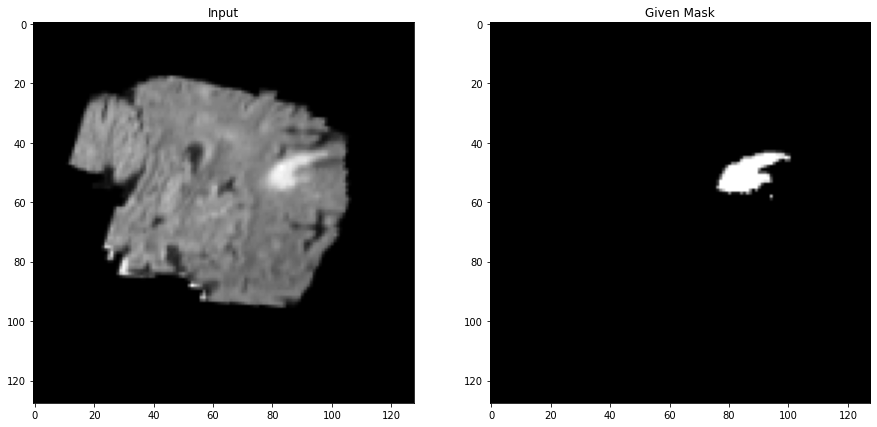

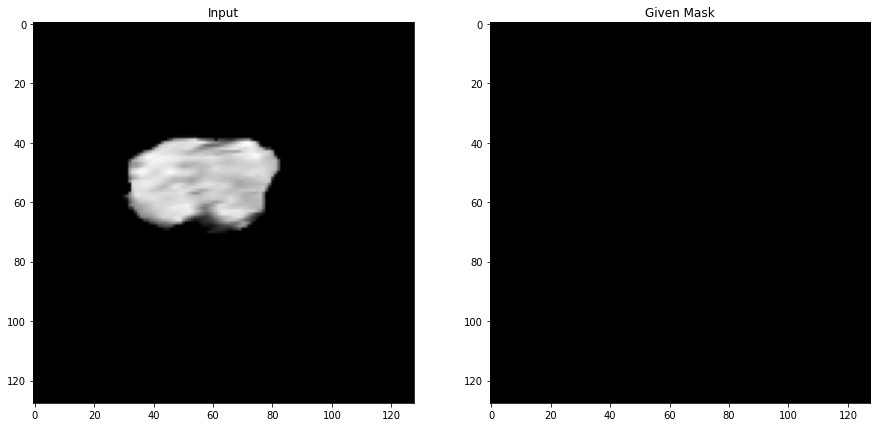

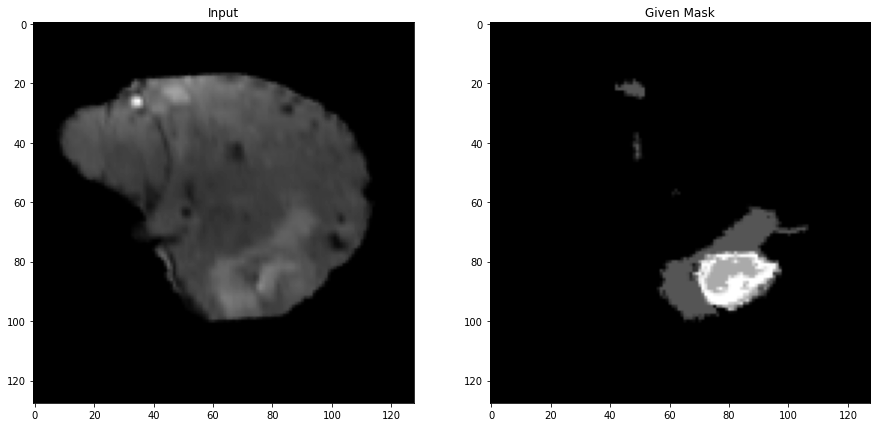

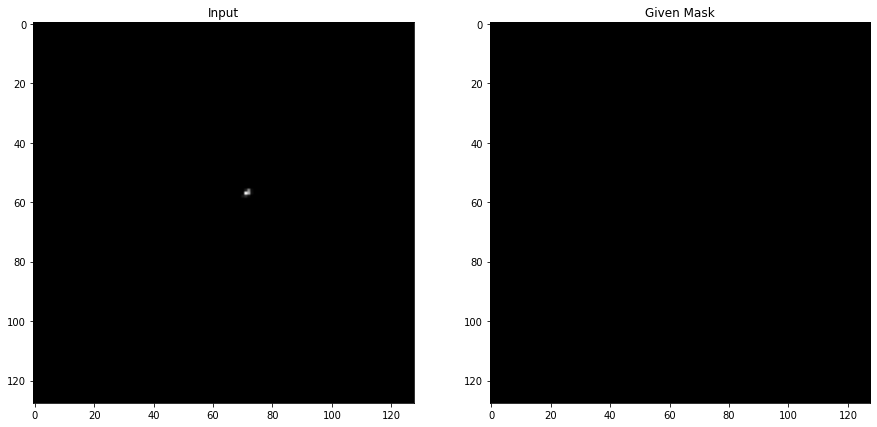

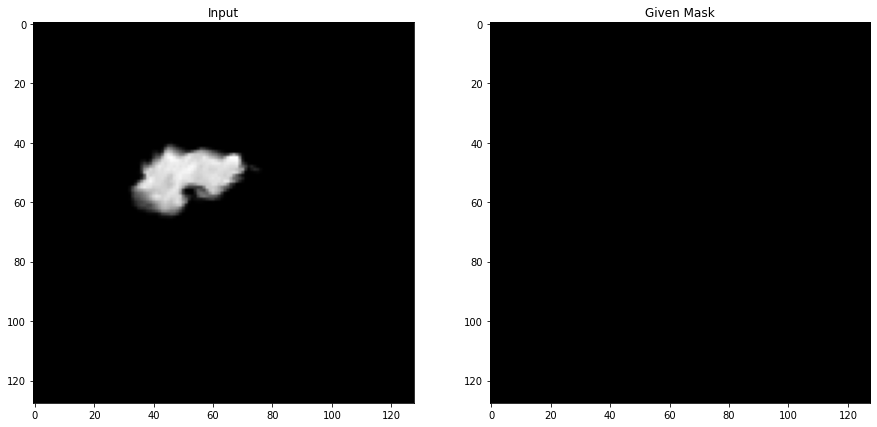

In [ ]:
show_data(train_generator, 5)

In [ ]:
def Model(num_levels, init_features=32, num_blocks=2, kernel_size=3, pool_size=2, input_channels=1, output_channels=1):
    inputs = keras.layers.Input(shape=(HEIGHT, WIDTH, input_channels))
    X = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    # Contraction part
    skips = {}
    for depth in range(num_levels):
        for _ in range(num_blocks):
            X = keras.layers.Conv2D(init_features * 2 ** depth, **convpars)(X)
        if depth < num_levels - 1:
            skips[depth] = X
            X = keras.layers.MaxPool2D(pool_size)(X)
            
    # Expansion part
    for depth in reversed(range(num_levels-1)):
        X = keras.layers.Conv2DTranspose(init_features * 2 ** depth, strides=pool_size, **convpars)(X)
        X = keras.layers.Concatenate()([X, skips[depth]])
        for _ in range(num_blocks):
            X = keras.layers.Conv2D(init_features * 2 ** depth, **convpars)(X)
            
    # Output layer
    activation_func = 'sigmoid'
    Y = keras.layers.Conv2D(output_channels, kernel_size=1, activation=activation_func, padding='same')(X)
    
    return keras.Model(inputs=[inputs], outputs=[Y], name=f'UNET-L{num_levels}-F{init_features}')

In [ ]:
STEPS_PER_EPOCH_TRAIN = TRAIN_SIZE // TRAIN_BATCH_SIZE
STEPS_PER_EPOCH_TEST = TEST_SIZE // TEST_BATCH_SIZE

model = Model(5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "UNET-L5-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor='val_loss', mode='min')
model_history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=STEPS_PER_EPOCH_TRAIN, 
                    validation_data=validate_generator, 
                    validation_steps=STEPS_PER_EPOCH_TEST,
                    epochs=EPOCHS,
                    callbacks = [callbacks])

Epoch 1/25


KeyboardInterrupt: ignored

#Plotting graph for overall loss

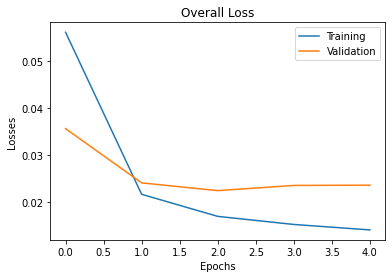

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Overall Loss')
plt.legend(['Training', 'Validation'])
plt.yscale('linear')
plt.savefig('/content/drive/MyDrive/slices/results/overall_loss')
plt.show()

#Saving the trained model

In [ ]:
model.save("/content/drive/MyDrive/slices/results/model.h5")

#Loading trained model

In [ ]:
model = load_model("/content/drive/MyDrive/slices/results/model.h5")

In [ ]:
# Defining a method to calculate dice score
def calculate_dice_score(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    is_NaN = math.isnan(dice)
    if is_NaN == True:
        dice = 0
    return dice

In [ ]:
# A method to display predictions from training data
def show_train_predictions(datagen, num=1):
    for i in range(0,num):
        img,msk = next(datagen)
        predicted_mask = model.predict(img)[0] > 0.5 # Thresholding the predictions for getting accurate predictions
        show([img[0], msk[0], predicted_mask])
        dice_score = calculate_dice_score(msk[0], predicted_mask, k = 1)
        print("Dice score : " + str(dice_score))

# A method to display predictions from validation data
def show_validation_predictions(datagen, num=1):
    for i in range(0,num):
        img,msk = next(datagen)
        predicted_mask = model.predict(img)[0] > 0.5 # Thresholding the predictions for getting accurate predictions
        show([img[0], msk[0], predicted_mask])
        dice_score = calculate_dice_score(msk[0], predicted_mask, k = 1)
        print("Dice score : " + str(dice_score))

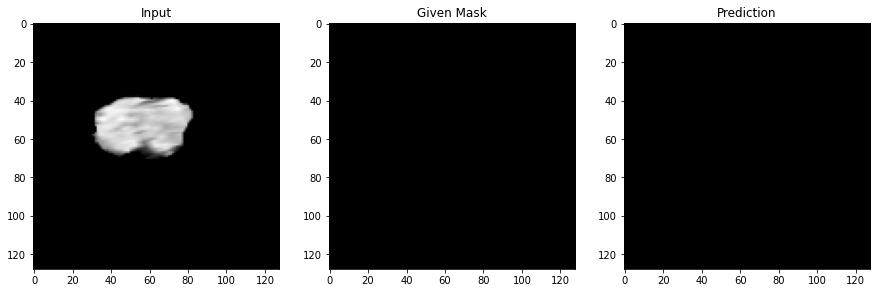

Dice score : 0


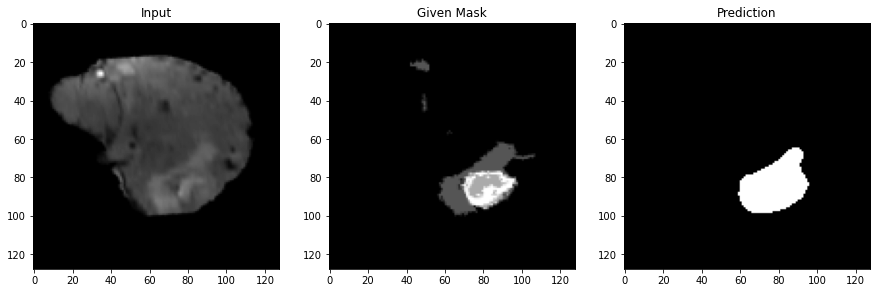

Dice score : 0.6763078464365063


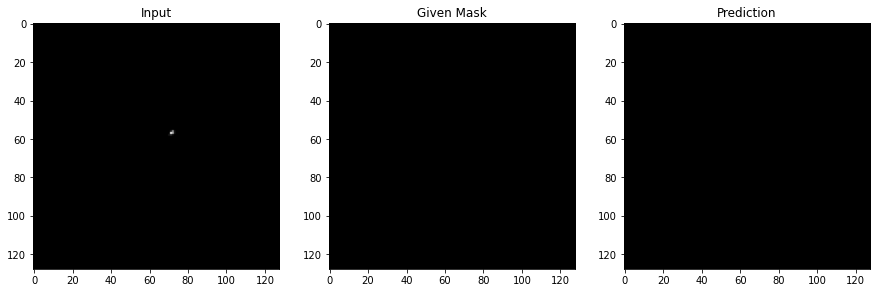

Dice score : 0


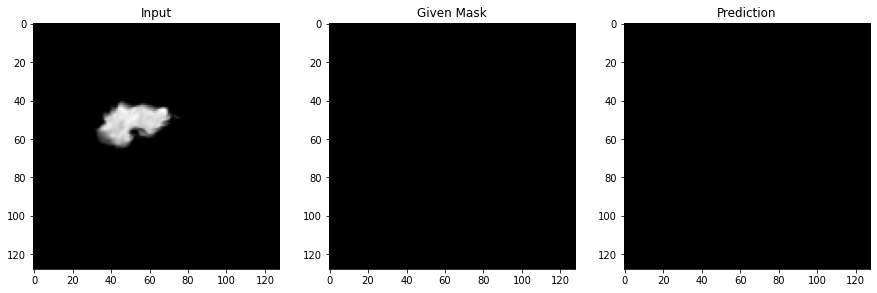

Dice score : 0


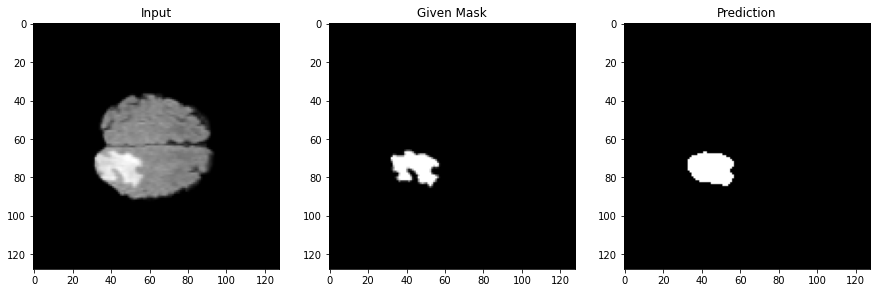

Dice score : 0.8812274401107463


In [ ]:
show_train_predictions(train_generator, 5)

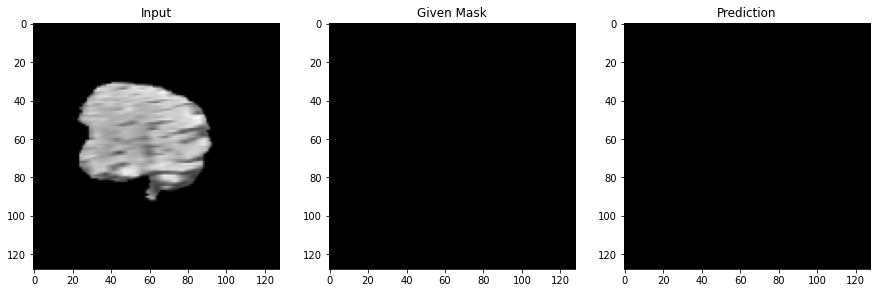

Dice score : 0


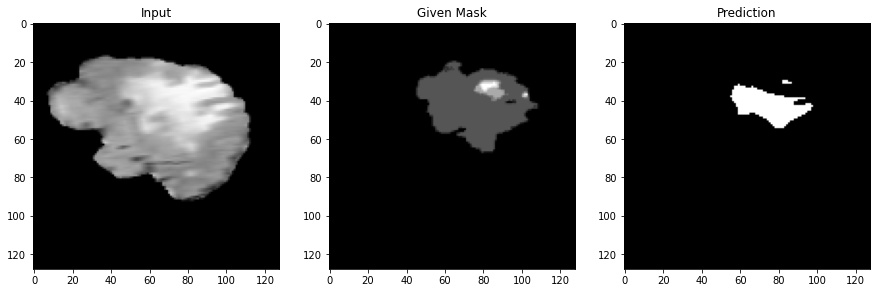

Dice score : 0.31130344175560015


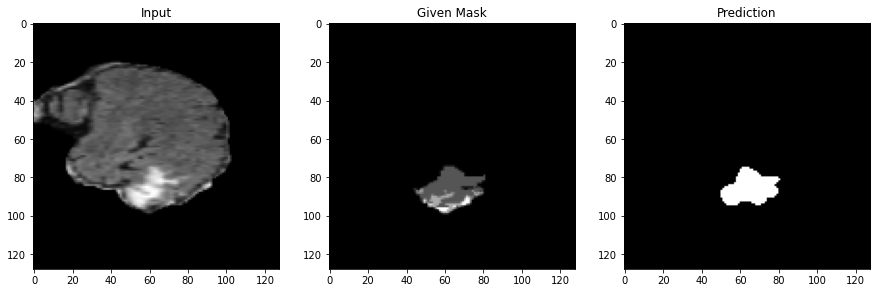

Dice score : 0.49390386233355843


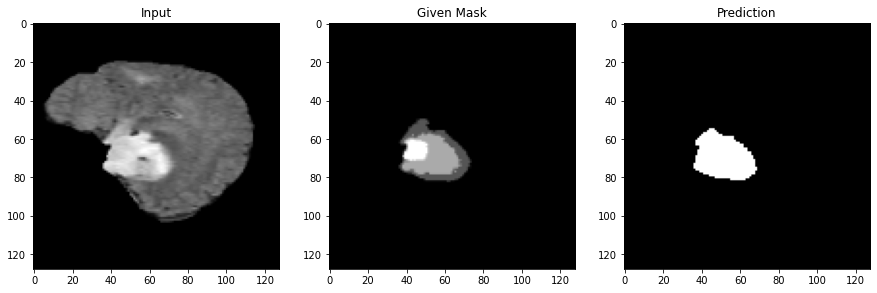

Dice score : 0.7289528484443499


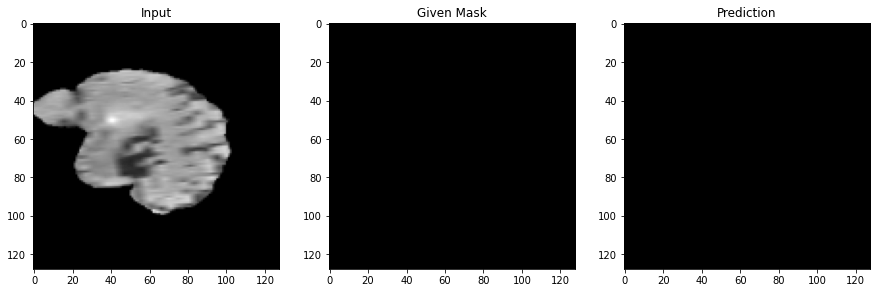

Dice score : 0


In [ ]:
show_validation_predictions(validate_generator, 5)

In [ ]:
test_generator = testing_genertor(test_image_dir, TEST_BATCH_SIZE)

Found 6531 images belonging to 1 classes.


In [ ]:
def display_test_data(data_list):
    plt.figure(figsize=(10,10))
    
    title = ['Input Image', 'Predicted Mask']
    
    for i in range(0, len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(data_list[i]), cmap='gray')
    plt.show()

def show_test_predictions(datagen, num=1):
    for i in range(0,num):
        image= next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display_test_data([image[0], pred_mask])

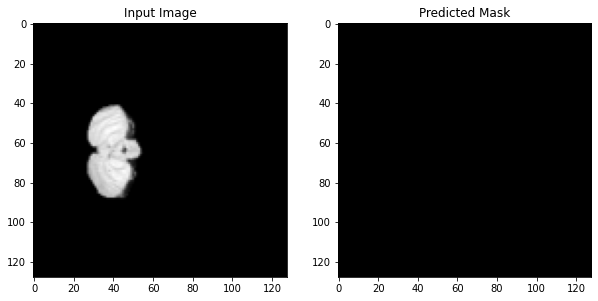

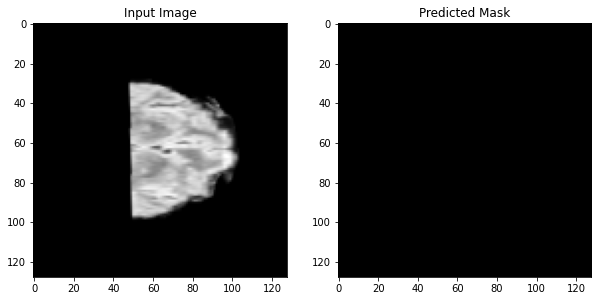

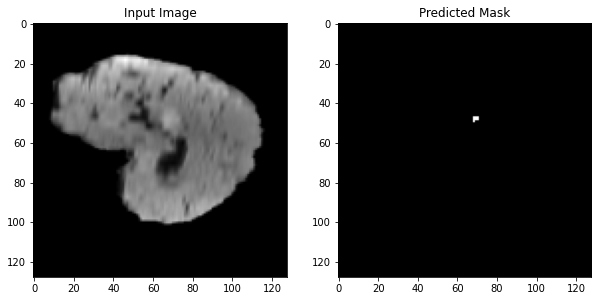

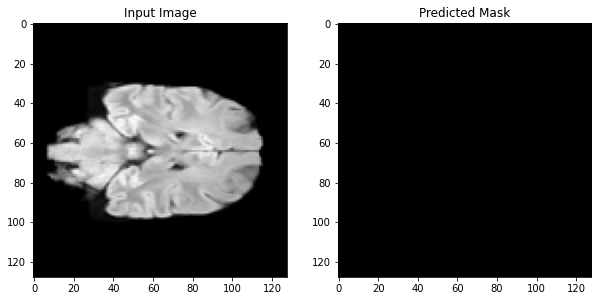

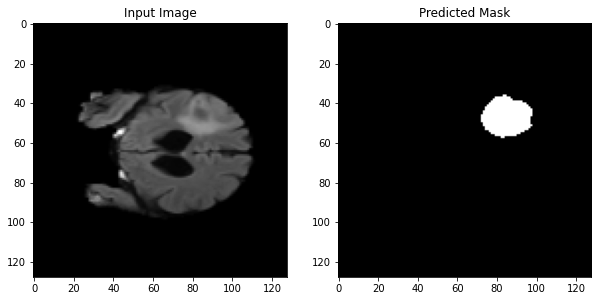

In [ ]:
show_test_predictions(test_generator, 5)